In [11]:
import pandas as pd

file = '../data/palm_ffb.csv'

def load_data(file):
    df = pd.read_csv(file, delimiter=',', parse_dates=['Date'], dayfirst=True)

    df.head()
    return df 

df = load_data(file)

df.head()


,Date,SoilMoisture,Average_Temp,Min_Temp,Max_Temp,Precipitation,Working_days,HA_Harvested,FFB_Yield
0,2008-01-01,616.4,25.306452,21.3,32.2,184.4,25,777778.3951,1.62
1,2008-02-01,568.9,26.165517,20.9,35.1,140.2,23,767988.2759,1.45
2,2008-03-01,577.6,25.448387,21.3,32.9,280.4,25,783951.9231,1.56
3,2008-04-01,581.1,26.903333,20.6,34.8,173.3,25,788987.0504,1.39
4,2008-05-01,545.4,27.241935,20.9,35.0,140.6,25,813659.7222,1.44


In [12]:
def external_factor_data(file):
   
    selected_columns = ['SoilMoisture', 'Average_Temp', 'Min_Temp', 'Max_Temp', 'Precipitation', 'Working_days', 'FFB_Yield']
    
   
    missing_columns = [col for col in selected_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing columns in the DataFrame: {', '.join(missing_columns)}")
    
    result_df = df[selected_columns]
    return result_df 

ex_data = external_factor_data(file)
ex_data.head()

,SoilMoisture,Average_Temp,Min_Temp,Max_Temp,Precipitation,Working_days,FFB_Yield
0,616.4,25.306452,21.3,32.2,184.4,25,1.62
1,568.9,26.165517,20.9,35.1,140.2,23,1.45
2,577.6,25.448387,21.3,32.9,280.4,25,1.56
3,581.1,26.903333,20.6,34.8,173.3,25,1.39
4,545.4,27.241935,20.9,35.0,140.6,25,1.44


In [13]:
import pandas as pd
import numpy as np

def preprocess_dataframe(data, numeric_columns):

    data = data.copy()
    
   
    if 'Date' in data.columns:
        data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y')
    
  
    if 'Working_days' in data.columns:
        data.loc[:, 'Working_days'] = data['Working_days'].astype(float)
    
   
    data = data.drop_duplicates()
    
  
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    
  
    data.dropna(inplace=True)

   
    for column in numeric_columns:
        if column in data.columns:
            Q1 = data[column].quantile(0.25)
            Q3 = data[column].quantile(0.75)
            IQR = Q3 - Q1
           
            data = data[~((data[column] < (Q1 - 1.5 * IQR)) | (data[column] > (Q3 + 1.5 * IQR)))]

    return data



numeric_columns = [col for col in ex_data.columns if pd.api.types.is_numeric_dtype(ex_data[col])]


preprocessed_data = preprocess_dataframe(ex_data, numeric_columns)


print("Preprocessed DataFrame:")
preprocessed_data.tail()


Preprocessed DataFrame:


,SoilMoisture,Average_Temp,Min_Temp,Max_Temp,Precipitation,Working_days,FFB_Yield
125,498.2,27.213333,21.6,33.6,165.6,24,1.29
126,494.7,27.074194,21.2,33.5,154.7,26,1.42
127,478.8,27.016129,20.4,33.6,127.2,25,1.61
128,481.1,26.946667,21.0,34.2,180.6,23,1.91
129,510.8,26.819355,21.0,34.4,207.0,26,2.04


Fitur yang dihapus: set()


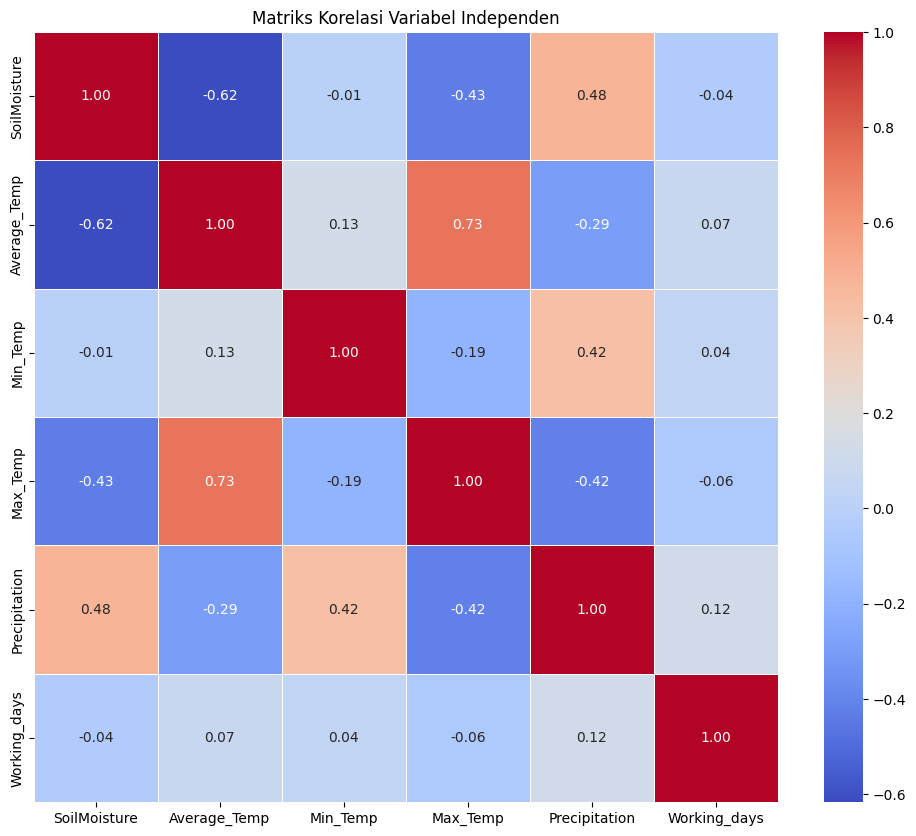

In [14]:
def correlation_matrix_visualization(correlation_matrix):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
   
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Matriks Korelasi Variabel Independen')
    plt.show()

def calculate_correlation_matrix(df, threshold=0.8):
    import numpy as np

    X = df[['SoilMoisture', 'Average_Temp', 'Min_Temp', 'Max_Temp', 'Precipitation', 'Working_days']]
   
    correlation_matrix = X.corr()
    
    high_correlation_variable = np.where(np.abs(correlation_matrix) > threshold)
  
    high_correlation_pairs = [(correlation_matrix.columns[x], correlation_matrix.columns[y])
                              for x, y in zip(*high_correlation_variable)
                              if x != y and x < y]

    
    for pair in high_correlation_pairs:
        print(pair, "-> Korelasi:", correlation_matrix.loc[pair[0], pair[1]])

    features_to_remove = set([pair[1] for pair in high_correlation_pairs])

   
    X_dropped = X.drop(columns=features_to_remove)

    print("Fitur yang dihapus:", features_to_remove)

    return X_dropped, correlation_matrix

X_dropped, correlation_matrix = calculate_correlation_matrix(preprocessed_data)
correlation_matrix_visualization(correlation_matrix)


In [15]:
def identification_multicollinearity(df):
    
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    from statsmodels.tools.tools import add_constant

    X = df[['SoilMoisture', 'Average_Temp', 'Min_Temp', 'Max_Temp', 'Precipitation', 'Working_days']]

    X_with_const = add_constant(X)
    
    vif_data = pd.DataFrame()
    
    vif_data["Variable"] = X_with_const.columns
    
    vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

    
    return vif_data

identification_multicollinearity(preprocessed_data)

,Variable,VIF
0,const,5974.672667
1,SoilMoisture,1.992389
2,Average_Temp,3.451316
3,Min_Temp,1.496976
4,Max_Temp,2.772080
5,Precipitation,1.803813
6,Working_days,1.053250


In [16]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from prettytable import PrettyTable
import statsmodels.api as sm

def multiple_linear_regression(df):
   
    X = df[['SoilMoisture', 'Average_Temp', 'Min_Temp', 'Precipitation', 'Working_days']]
    y = df['FFB_Yield']

    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    
    X_scaled = sm.add_constant(X_scaled)
    model = sm.OLS(y, X_scaled).fit()

    table = PrettyTable()
    table.field_names = ["Variable", "Coefficient", "Standard Error", "t-Value", "p-Value"]

    for i, variable in enumerate(model.params.index):
        table.add_row([
            variable,
            f"{model.params[variable]:.4f}",
            f"{model.bse[variable]:.4f}",
            f"{model.tvalues[variable]:.4f}",
            f"{model.pvalues[variable]:.4f}"
        ])

    table.add_row(["R-squared", f"{model.rsquared:.4f}", "", "", ""])
    table.add_row(["Adjusted R-squared", f"{model.rsquared_adj:.4f}", "", "", ""])

    return table

summary_table = multiple_linear_regression(df)
print("Model Summary:")
print(summary_table)


Model Summary:
+--------------------+-------------+----------------+---------+---------+
|      Variable      | Coefficient | Standard Error | t-Value | p-Value |
+--------------------+-------------+----------------+---------+---------+
|       const        |    1.6022   |     0.0236     | 68.0093 |  0.0000 |
|         x1         |   -0.0653   |     0.0347     | -1.8797 |  0.0625 |
|         x2         |    0.0018   |     0.0324     |  0.0563 |  0.9552 |
|         x3         |   -0.0129   |     0.0269     | -0.4785 |  0.6332 |
|         x4         |    0.1206   |     0.0317     |  3.8018 |  0.0002 |
|         x5         |    0.0143   |     0.0241     |  0.5917 |  0.5551 |
|     R-squared      |    0.1263   |                |         |         |
| Adjusted R-squared |    0.0911   |                |         |         |
+--------------------+-------------+----------------+---------+---------+


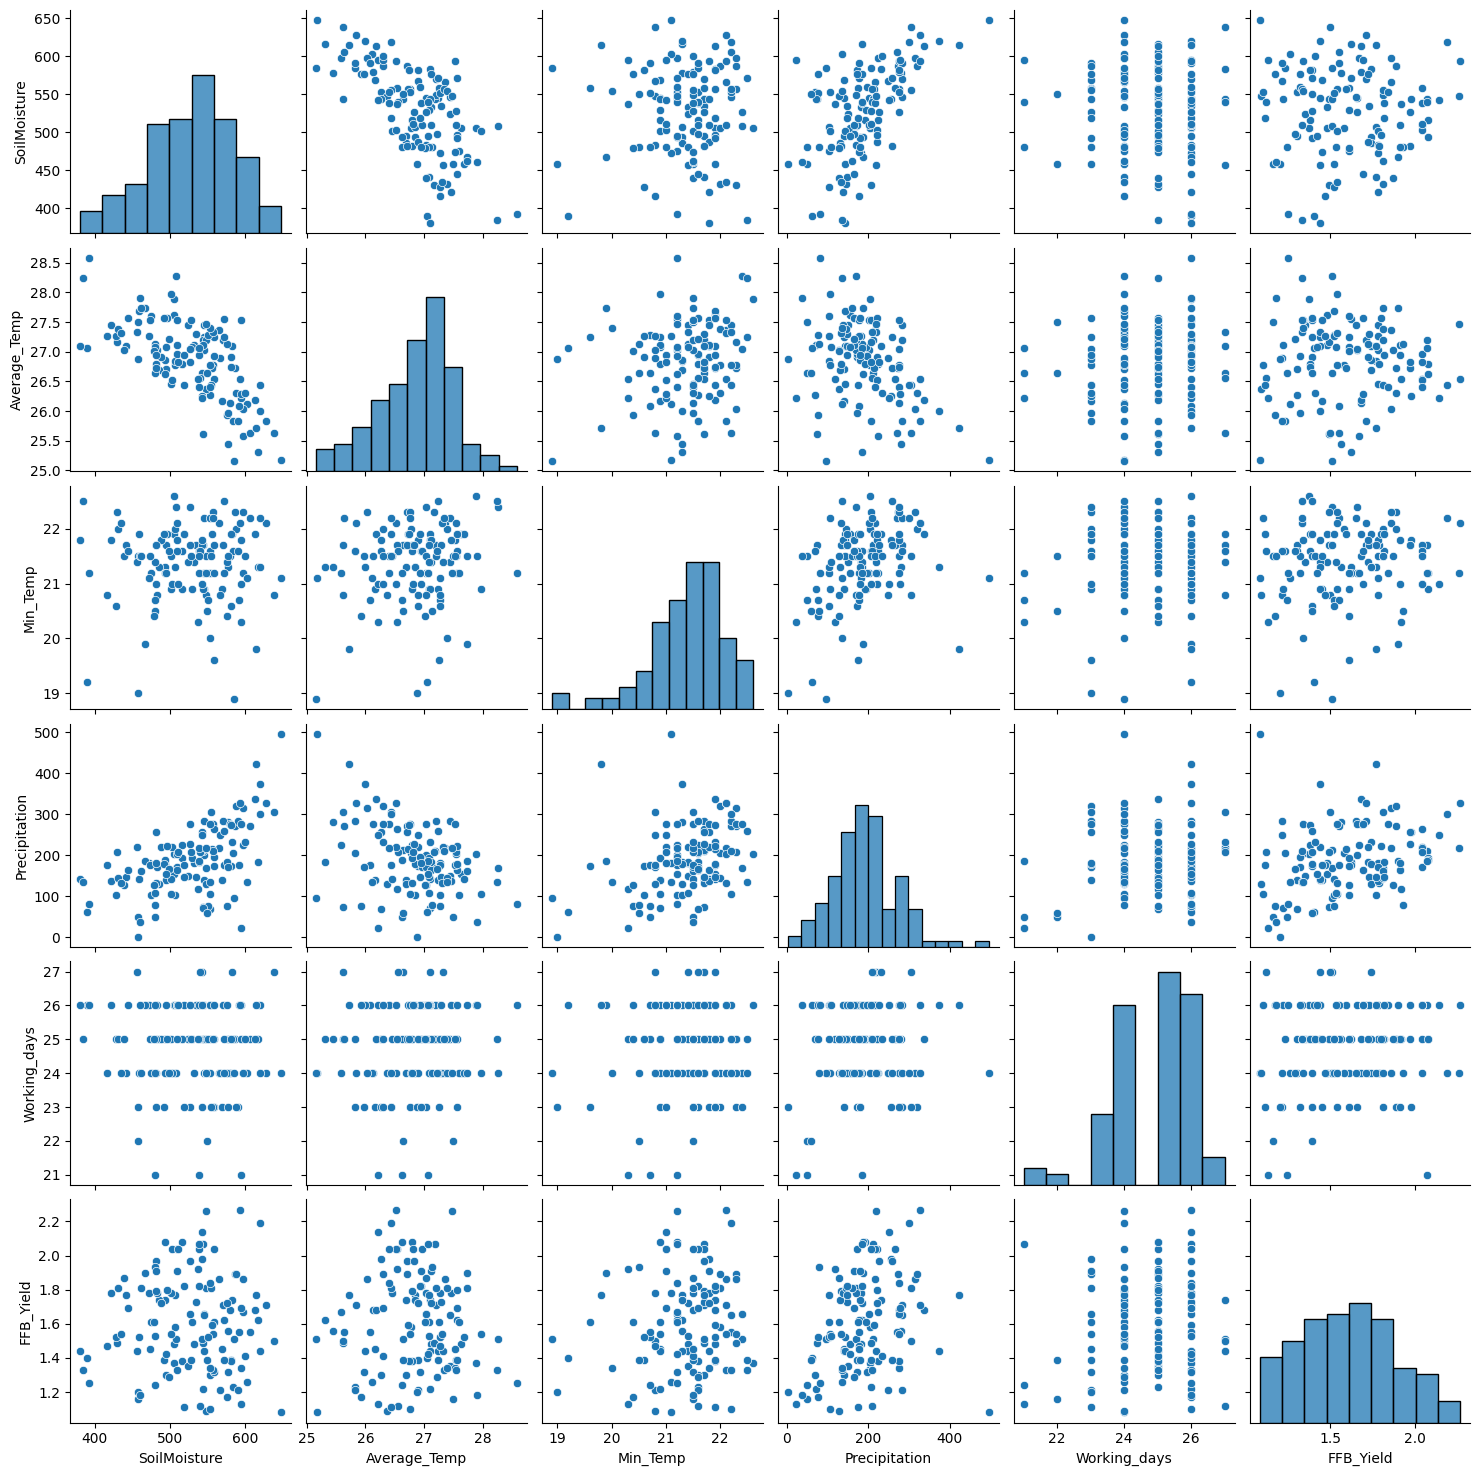

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month

# Pair Plot
sns.pairplot(df[['SoilMoisture', 'Average_Temp', 'Min_Temp', 'Precipitation', 'Working_days', 'FFB_Yield']])
plt.show()


In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score


X = df[['SoilMoisture', 'Average_Temp', 'Min_Temp', 'Precipitation', 'Working_days']]
y = df['FFB_Yield']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


pipeline_poly = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('model', LinearRegression())
])


pipeline_poly.fit(X_train, y_train)


y_pred_poly = pipeline_poly.predict(X_test)


mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print(f'Polinomial Regression MSE: {mse_poly}')
print(f'Polinomial Regression R^2: {r2_poly}')


pipeline_dt = Pipeline([
    ('model', DecisionTreeRegressor())
])


pipeline_dt.fit(X_train, y_train)


y_pred_dt = pipeline_dt.predict(X_test)


mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print(f'Decision Tree Regressor MSE: {mse_dt}')
print(f'Decision Tree Regressor R^2: {r2_dt}')


pipeline_rf = Pipeline([
    ('model', RandomForestRegressor())
])


pipeline_rf.fit(X_train, y_train)


y_pred_rf = pipeline_rf.predict(X_test)


mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest Regressor MSE: {mse_rf}')
print(f'Random Forest Regressor R^2: {r2_rf}')


Polinomial Regression MSE: 0.09890384840283567
Polinomial Regression R^2: -0.13872138924580146
Decision Tree Regressor MSE: 0.15418076923076923
Decision Tree Regressor R^2: -0.7751477072798527
Random Forest Regressor MSE: 0.0721873903846154
Random Forest Regressor R^2: 0.1688763704118772
